In [19]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os


In [ ]:
# Image Preprocess Method
def preprocess_image(image_path):
    img = Image.open(image_path).convert("RGB")

    # Define preprocessing transformations
    preprocess = transforms.Compose([
        transforms.Resize((244, 244)),  # Resize to 244x244
        transforms.ToTensor(),          # Convert to tensor (scales to [0, 1])
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for ResNet50
    ])

    img_tensor = preprocess(img)  # Apply transformations
    img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension
    return img_tensor


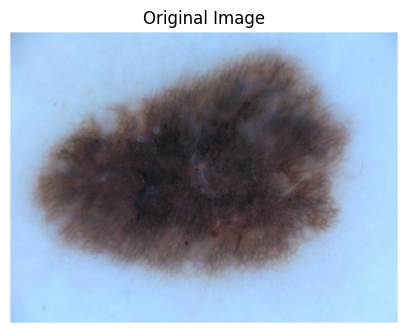

In [ ]:
# Original Example Image

image_path = r"archive\ISIC_2019_Training_Input\ISIC_0000000.jpg"

# Open and display the original image
img = Image.open(image_path).convert("RGB")
plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")
plt.show()

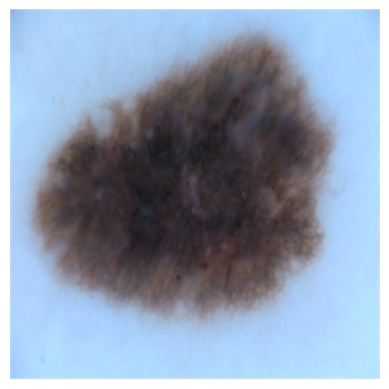

In [ ]:
# Preprocessed Example Image

image_path = r"archive\ISIC_2019_Training_Input\ISIC_0000000.jpg"
img_tensor = preprocess_image(image_path)


def show_image(tensor):
    # Remove batch dimension
    img = tensor.squeeze(0)

    # Reverse normalization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img * std + mean  # Unnormalize

    # Convert to NumPy and transpose channels
    img = img.numpy().transpose(1, 2, 0)

    # Display image
    plt.imshow(img)
    plt.axis("off")  # Hide axes
    plt.show()

show_image(img_tensor)


In [ ]:
csv_file = 'archive/ISIC_2019_Training_GroundTruth.csv'
data = pd.read_csv(csv_file)

# Find Paths to each image
image_paths = [os.path.join('archive/ISIC_2019_Training_Input', f'{img_id}.jpg') for img_id in data.iloc[:, 0]]

# All columns except the first one, which is the image name
labels = data.iloc[:, 1:].values.astype('float32')  

#print(image_paths)


In [16]:
# Define the batch size and DataLoader
batch_size = 32
dataset_size = len(image_paths)

# Define DataLoader
def collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack(images)  # Stack images into a batch tensor
    labels = torch.stack(labels)  # Stack labels into a batch tensor
    return images, labels

In [17]:
# Load images and labels into batches
def load_data(image_paths, labels, batch_size):
    data_loader = []
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]
        batch_labels = labels[i:i+batch_size]
        
        batch_images = []
        for path in batch_paths:
            image = preprocess_image(path)  # Apply the preprocessing
            batch_images.append(image)
        
        batch_labels = torch.tensor(batch_labels)  # Convert labels to tensor
        data_loader.append((torch.stack(batch_images), batch_labels))
    
    return data_loader

train_loader = load_data(image_paths, labels, batch_size)

In [ ]:




# Load pre-trained ResNet50
model = models.resnet50(pretrained=True)

# Modify the final layer for multi-label classification (9 classes)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 9)  # 7 output classes (MEL, NV, BCC, etc.)
)

# Set device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Multi-label classification loss
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()  # Zero the gradients
        
        if inputs.dim() == 5:  # In case there's an extra dimension due to stacking
            inputs = inputs.squeeze(1)  # Remove the extra dimension

        outputs = model(inputs)  # Forward pass
        
        # Calculate loss
        loss = criterion(outputs, labels)
        
        loss.backward()  # Backward pass
        optimizer.step()  # Update parameters
        
        running_loss += loss.item()  # Accumulate loss
        
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# Save the trained model
torch.save(model.state_dict(), "resnet50_skin_cancer_model.pth")

ValueError: Target size (torch.Size([32, 9])) must be the same as input size (torch.Size([32, 7]))